#### Set up Dataset - A binary subset of CIFAR 10

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import DenseNet121, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from movies.inference import load_model

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a binary subset for classes 'cat' (label 3) and 'dog' (label 5)
binary_classes = [3, 5]
train_filter = np.isin(y_train, binary_classes).reshape(-1)
test_filter = np.isin(y_test, binary_classes).reshape(-1)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Map labels to binary (0 and 1)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Split a portion of x_train and y_train for validation
validation_split = 0.2
num_validation_samples = int(validation_split * len(x_train))

x_val, y_val = x_train[:num_validation_samples], y_train[:num_validation_samples]
x_train, y_train = x_train[num_validation_samples:], y_train[num_validation_samples:]

# Resize images to match input size for pretrained models (224x224)
IMG_SIZE = (224, 224)

# Resizing function for CIFAR-10 images
def preprocess_images(images):
    return np.array([tf.image.resize(image, IMG_SIZE).numpy() for image in images])

x_train_resized = preprocess_images(x_train)
x_val_resized = preprocess_images(x_val)
x_test_resized = preprocess_images(x_test)

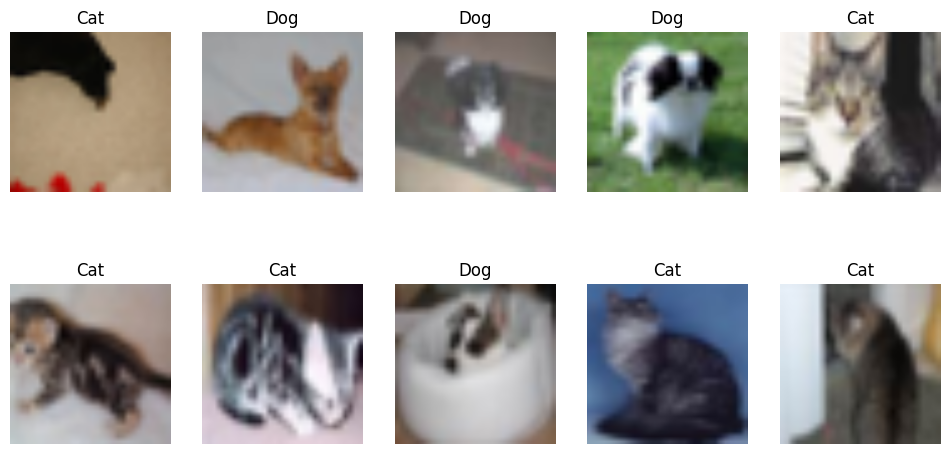

In [17]:
# Define class names for display
class_names = ["Cat", "Dog"]

# Function to display sample images
def display_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[labels[i][0]])
        plt.axis("off")
    plt.show()

# Display 10 sample images from the resized training dataset
display_sample_images(x_train_resized, y_train, class_names, num_images=10)


In [18]:
x_train_resized.shape

(8000, 224, 224, 3)

#### Preprocessing and Augmentation

In [20]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(x_train_resized, y_train, batch_size=32)
test_gen = test_datagen.flow(x_test_resized, y_test, batch_size=32)
val_gen = test_datagen.flow(x_val_resized, y_val, batch_size=32)

In [21]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inception_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

def preprocess_for_inception_resnet(generator):
    """
    Preprocesses images from a generator for InceptionResNetV2.
    """
    for batch_x, batch_y in generator:
        yield preprocess_inception_resnet(batch_x), batch_y

def preprocess_for_vgg16(generator):
    """
    Preprocesses images from a generator for VGG16.
    """
    for batch_x, batch_y in generator:
        yield preprocess_vgg16(batch_x), batch_y

def preprocess_for_densenet(generator):
    """
    Preprocesses images from a generator for DenseNet121.
    """
    for batch_x, batch_y in generator:
        yield preprocess_densenet(batch_x), batch_y

# Example usage: to use these generators with preprocessed images
train_gen_inception = preprocess_for_inception_resnet(train_gen)
test_gen_inception = preprocess_for_inception_resnet(test_gen)
val_gen_inception = preprocess_for_inception_resnet(val_gen)

train_gen_vgg16 = preprocess_for_vgg16(train_gen)
test_gen_vgg16 = preprocess_for_vgg16(test_gen)
val_gen_vgg16 = preprocess_for_vgg16(val_gen)

train_gen_densenet = preprocess_for_densenet(train_gen)
test_gen_densenet = preprocess_for_densenet(test_gen)
val_gen_densenet = preprocess_for_densenet(val_gen)

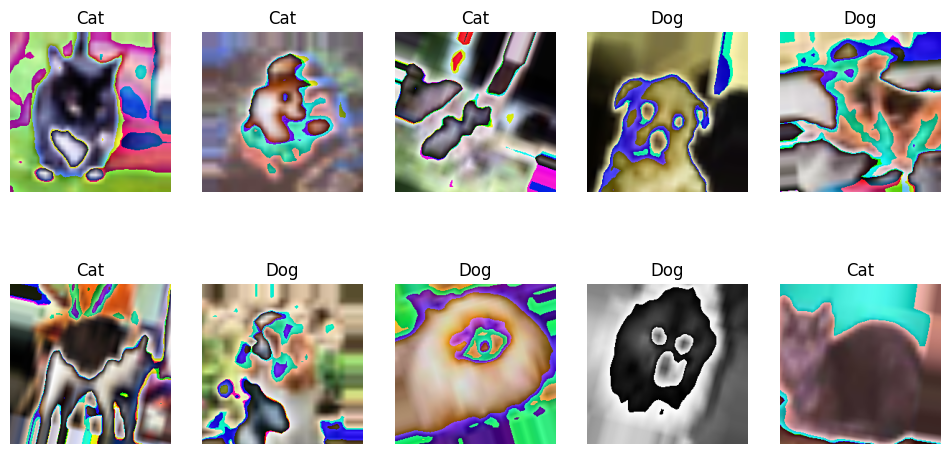

In [22]:
def display_sample_images_from_generator(generator, class_names, num_images=10):
    images, labels = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        
        plt.subplot(2, 5, i + 1)
        plt.imshow((images[i]*255).astype("uint8"))
        plt.title(class_names[labels[i][0]])
        plt.axis("off")
    plt.show()

# Example usage with training generator
display_sample_images_from_generator(train_gen_inception, class_names, num_images=10)


#### Creating Models
* DenseNet121
* VGG16
* InceptionResNetV2

In [23]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

def create_model(base_model_name, input_shape=(224, 224, 3), dropout_rate=0.5):
    """
    Creates a model based on the specified pretrained base model.

    Parameters:
    - base_model_name (str): Name of the base model ('DenseNet121', 'VGG16', 'InceptionResNetV2').
    - input_shape (tuple): Shape of the input images.
    - dropout_rate (float): Dropout rate for regularization.

    Returns:
    - model (Model): Compiled Keras model ready for training.
    """
    if base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionResNetV2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base_model_name. Choose from 'DenseNet121', 'VGG16', or 'InceptionResNetV2'.")

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model

In [28]:
def compile_and_train_model(model,
                            train_generator,
                            validation_generator,
                            learning_rate=1e-4,
                            epochs=20,
                            callbacks=None):
    """
    Compiles and trains the provided model.

    Parameters:
    - model (Model): Keras model to compile and train.
    - train_generator (Iterator): Training data generator.
    - validation_generator (Iterator): Validation data generator.
    - learning_rate (float): Learning rate for the optimizer.
    - epochs (int): Number of training epochs.
    - callbacks (list): List of Keras callbacks to apply during training.

    Returns:
    - history (History): Training history object.
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    if callbacks is None:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
        ]

    history = model.fit(
        train_generator,
        batch_size=32,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    return history


In [29]:
# Example hyperparameters
learning_rate = 1e-4
epochs = 20
dropout_rate = 0.5

# Dictionary to hold models and their corresponding preprocessed generators
models_info = {
    'DenseNet121': {
        'preprocess_function': preprocess_densenet,
        'train_gen': train_gen_densenet,
        'val_gen': val_gen_densenet,
        'test_gen': test_gen_densenet
    },
    'VGG16': {
        'preprocess_function': preprocess_vgg16,
        'train_gen': train_gen_vgg16,
        'val_gen': val_gen_vgg16,
        'test_gen': test_gen_vgg16
    },
    'InceptionResNetV2': {
        'preprocess_function': preprocess_inception_resnet,
        'train_gen': train_gen_inception,
        'val_gen': val_gen_inception,
        'test_gen': test_gen_inception
    }
}

trained_models = {}
training_histories = {}

for model_name, info in models_info.items():
    print(f"\n=== Training {model_name} ===")

    # Create the model
    model = create_model(base_model_name=model_name, dropout_rate=dropout_rate)

    # Compile and train the model
    history = compile_and_train_model(
        model=model,
        train_generator=info['train_gen'],
        validation_generator=info['val_gen'],
        learning_rate=learning_rate,
        epochs=epochs
    )

    # Save the trained model and history
    trained_models[model_name] = model
    training_histories[model_name] = history

    print(f"{model_name} training completed.\n")



=== Training DenseNet121 ===
Epoch 1/20
    861/Unknown 808s 935ms/step - accuracy: 0.5291 - loss: 0.9183

KeyboardInterrupt: 